In [2]:
print("Test2")

Test2


In [2]:
import pandas as pd

data = {
    'ID': range(0,10),
    'Name': ['Test1','Test2','Test3','Test4','Test5','Test6','Test7','Test8','Test9','Test10'],
    'Zahl': [32,34,7,4,34,2,11,9,3,36]
}

df = pd.DataFrame(data)

df

,ID,Name,Zahl
0,0,Test1,32
1,1,Test2,34
2,2,Test3,7
3,3,Test4,4
4,4,Test5,34
5,5,Test6,2
6,6,Test7,11
7,7,Test8,9
8,8,Test9,3
9,9,Test10,36


In [15]:
%matplotlib inline
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [19]:
data = TimeSeriesDataFrame.from_path(
    "https://autogluon.s3.amazonaws.com/datasets/timeseries/australian_electricity_subset/test.csv"
)
data.head()

target
item_id timestamp                       
T000000 2013-03-10 00:00:00  5207.959961
        2013-03-10 00:30:00  5002.275879
        2013-03-10 01:00:00  4747.569824
        2013-03-10 01:30:00  4544.880859
        2013-03-10 02:00:00  4425.952148

In [20]:
prediction_length = 48
train_data, test_data = data.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data, presets="bolt_small",
)

Sorting the dataframe index before generating the train/test split.
Beginning AutoGluon training...
AutoGluon will save models to 'c:\workspace\CrimeMap\AutogluonModels\ag-20250512_195114'
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.12.1
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          8
GPU Count:          0
Memory Avail:       0.57 GB / 15.70 GB (3.7%)
Disk Space Avail:   63.59 GB / 475.50 GB (13.4%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 48,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series freque

Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]


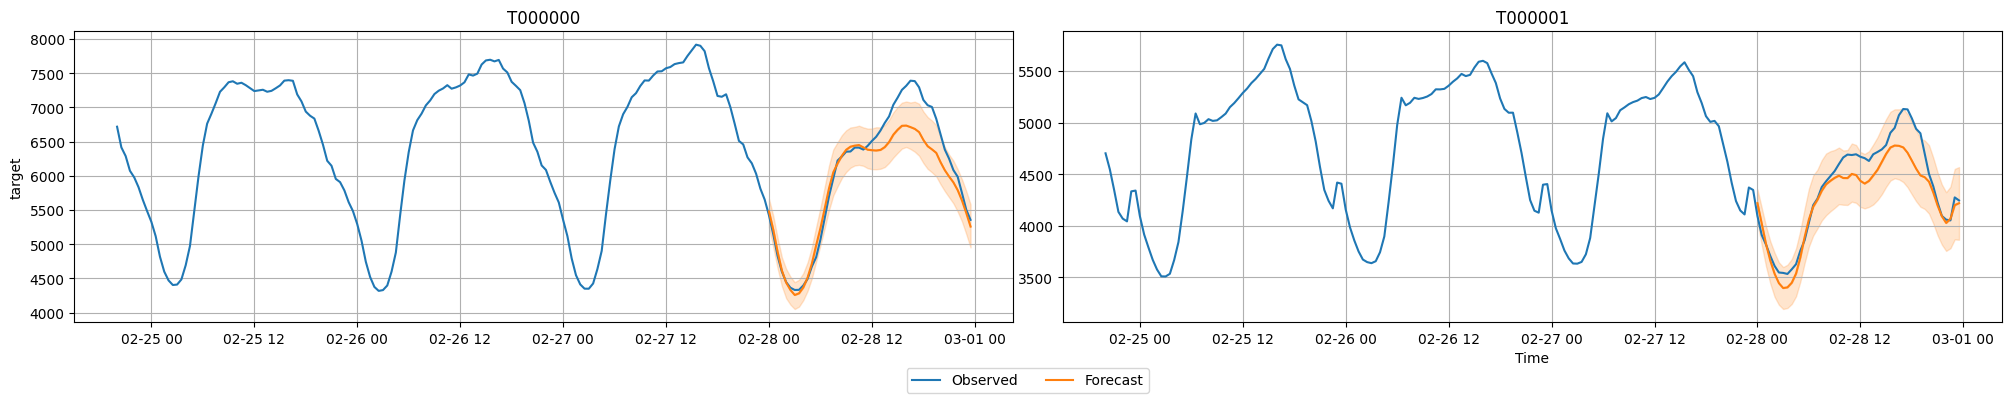

In [21]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=data,
    predictions=predictions,
    item_ids=data.item_ids[:2],
    max_history_length=200,
);

# Fine-Tuning

In [7]:
predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data=train_data,
    hyperparameters={
        "Chronos": [
            {"model_path": "bolt_small", "ag_args": {"name_suffix": "ZeroShot"}},
            {"model_path": "bolt_small", "fine_tune": True, "ag_args": {"name_suffix": "FineTuned"}},
        ]
    },
    time_limit=60,  # time limit in seconds
    enable_ensemble=False,
)

Beginning AutoGluon training... Time limit = 60s
AutoGluon will save models to 'c:\workspace\CrimeMap\AutogluonModels\ag-20250509_103757'
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.12.1
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          8
GPU Count:          0
Memory Avail:       0.88 GB / 15.70 GB (5.6%)
Disk Space Avail:   79.76 GB / 475.50 GB (16.8%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'model_path': 'bolt_small'}]},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 48,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,

In [ ]:
predictor.leaderboard(test_data)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
c:\workspace\CrimeMap\CrimeMap_venv\Lib\site-packages\autogluon\timeseries\metrics\abstract.py:101: FutureWarning: Passing `prediction_length` to `TimeSeriesScorer.__call__` is deprecated and will be removed in v2.0. Please set the `eval_metric.prediction_length` attribute instead.
  warnings.warn(
c:\workspace\CrimeMap\CrimeMap_venv\Lib\site-packages\autogluon\timeseries\metrics\abstract.py:101: FutureWarning: Passing `prediction_length` to `TimeSeriesScorer.__call__` is deprecated and will be removed in v2.0. Please set the `eval_metric.prediction_length` attribute instead.
  warnings.warn(


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,ChronosFineTuned[bolt_small],-0.040169,-0.039707,0.488883,0.502086,51.989371,2
1,ChronosZeroShot[bolt_small],-0.041446,-0.041720,1.927625,1.198816,0.147036,1


# Eigener Test

In [54]:
data = TimeSeriesDataFrame.from_path(
    "TempEsslingen24Monate.csv"
)
data.head()

target
item_id timestamp         
2023    2023-05-01    13.8
        2023-06-01    18.8
        2023-07-01    16.1
        2023-08-01    16.0
        2023-09-01    13.5

In [17]:
prediction_length = 5
train_data, test_data = data.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data, presets="bolt_small",
)

Beginning AutoGluon training...
AutoGluon will save models to 'c:\workspace\CrimeMap\AutogluonModels\ag-20250512_194913'
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.12.1
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          8
GPU Count:          0
Memory Avail:       0.70 GB / 15.70 GB (4.4%)
Disk Space Avail:   63.60 GB / 475.50 GB (13.4%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 5,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 7 rows, 2 time series. Median time 

Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]


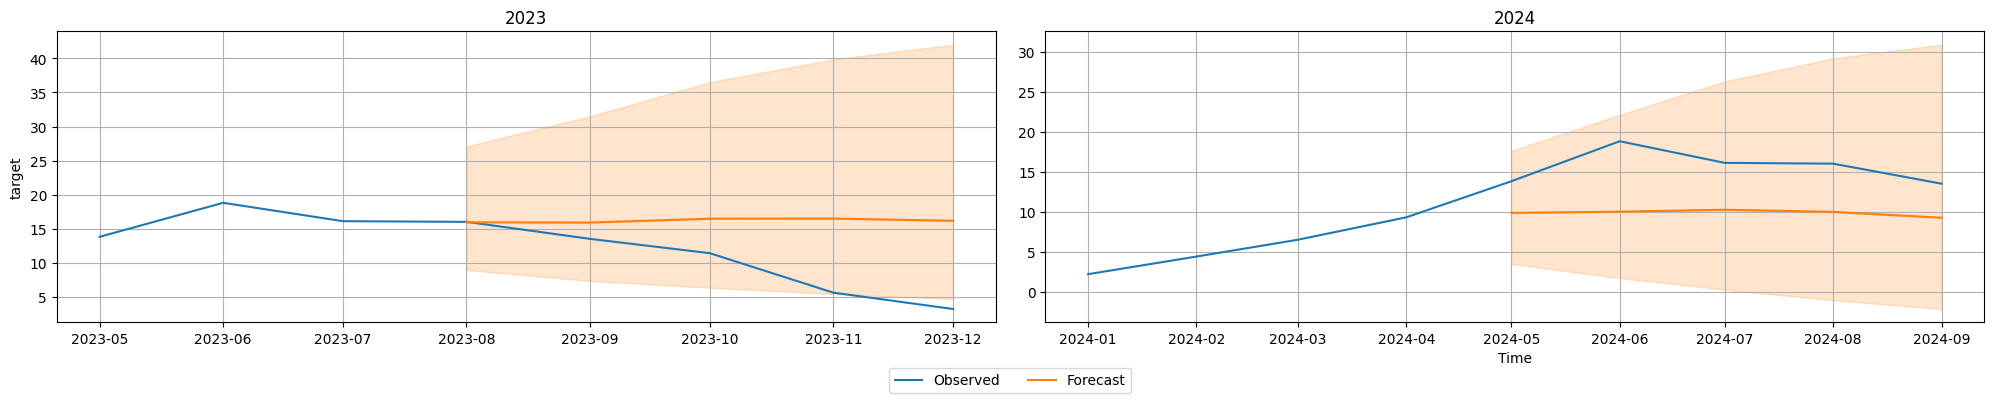

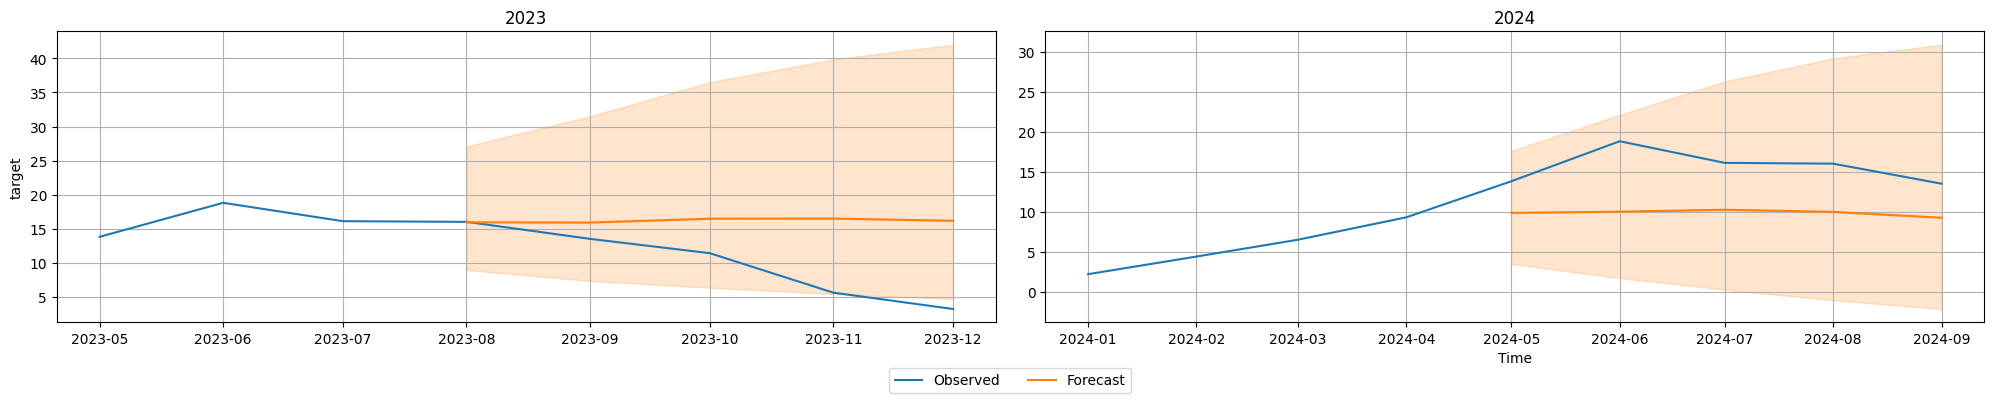

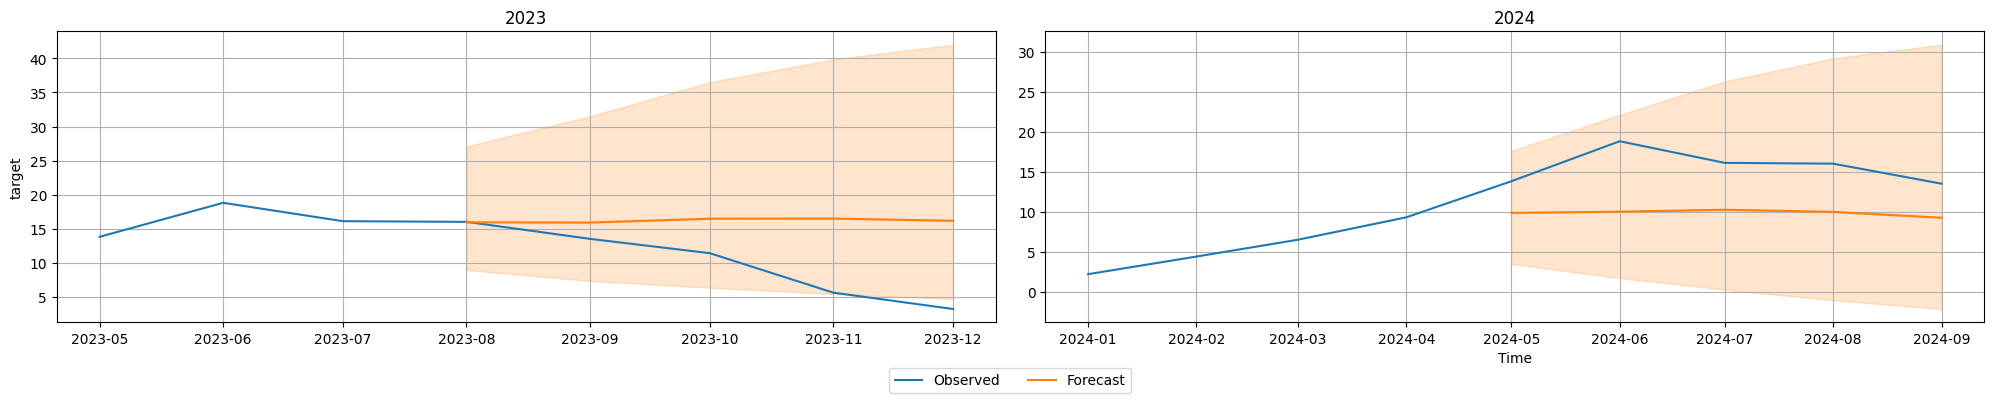

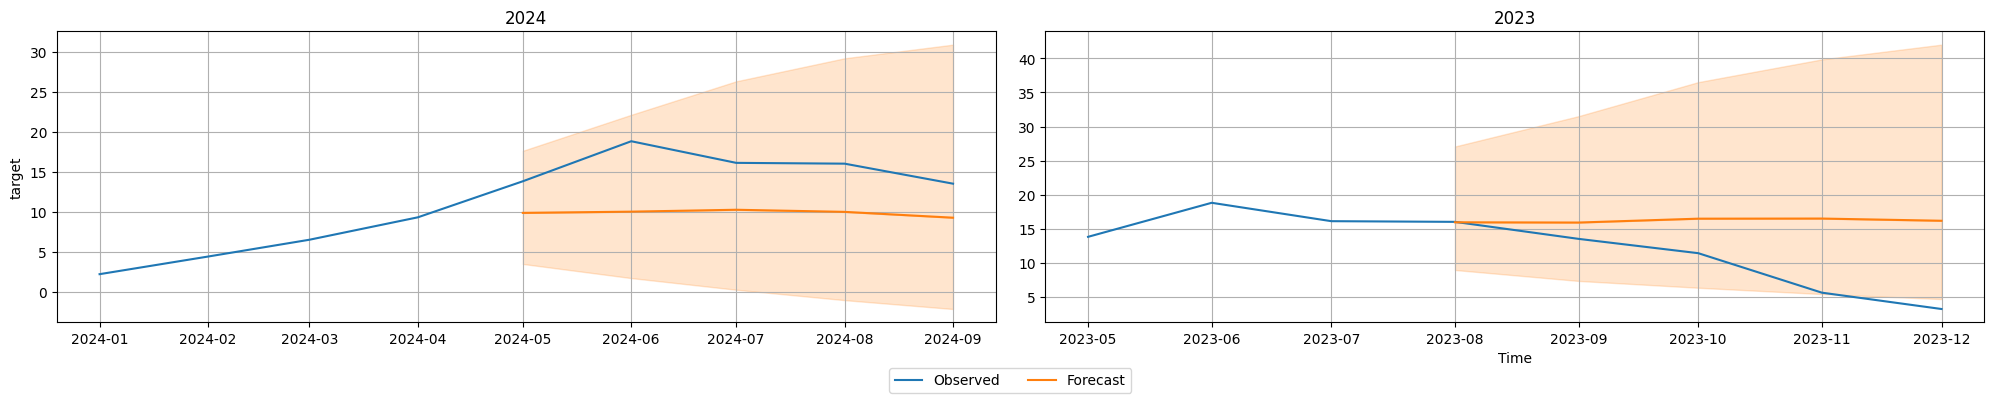

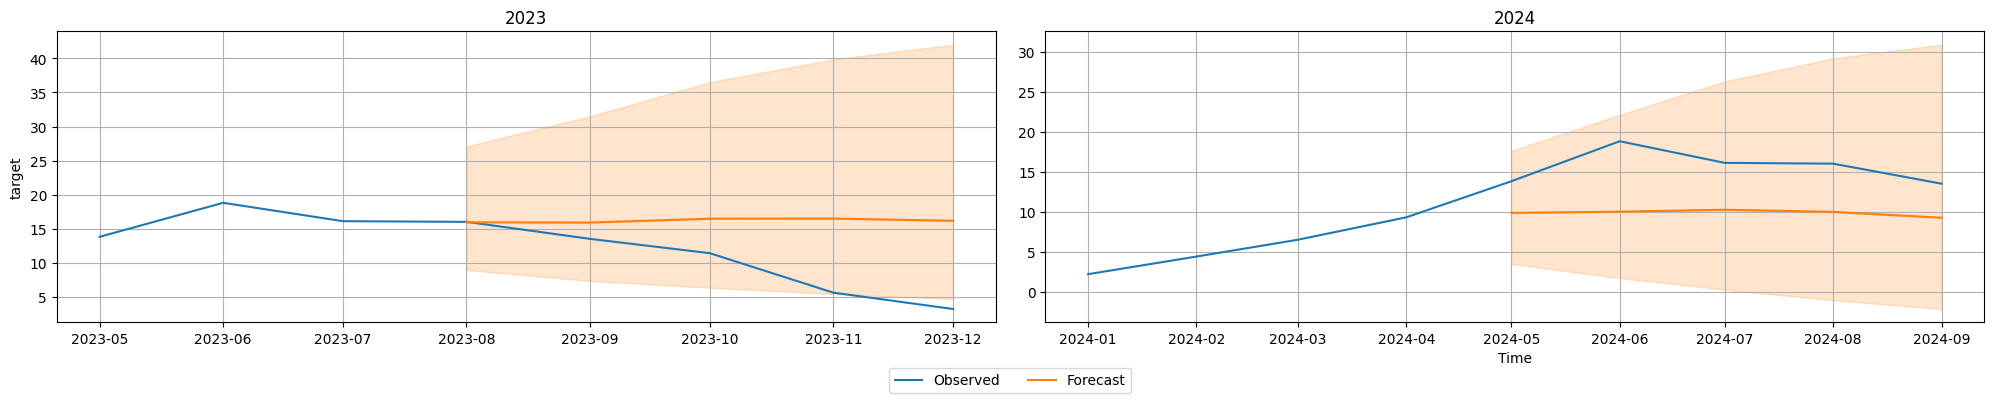

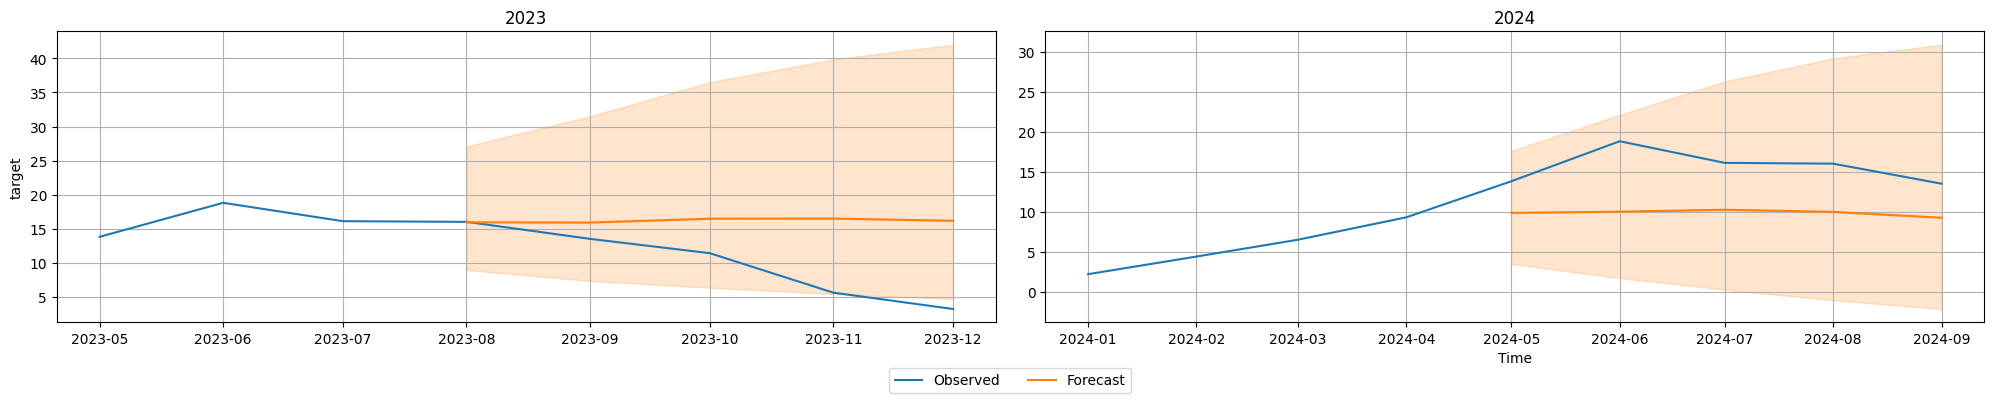

In [18]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=data,
    predictions=predictions,
    item_ids=data.item_ids[:2],
    max_history_length=200,
);

# Test Nummer 2

In [3]:
%matplotlib inline
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

c:\workspace\CrimeMap\CrimeMap_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [63]:
data = TimeSeriesDataFrame.from_path(
    "climate-series.csv"
)
data.head()

target
item_id timestamp            
1       2017-01-01  15.913043
        2017-01-02  18.500000
        2017-01-03  17.111111
        2017-01-04  18.700000
        2017-01-05  18.388889

In [49]:
prediction_length = 5
train_data, test_data = data.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length, freq="D").fit(
    train_data, presets="bolt_small",
)

Beginning AutoGluon training...
AutoGluon will save models to 'c:\workspace\CrimeMap\AutogluonModels\ag-20250512_213733'
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.12.1
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          8
GPU Count:          0
Memory Avail:       0.45 GB / 15.70 GB (2.9%)
Disk Space Avail:   62.49 GB / 475.50 GB (13.1%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'D',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 5,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Provided train_data has 55 rows, 11 time series. Median time series length is 5 (m

In [52]:
predictions.head()

mean        0.1        0.2        0.3        0.4  \
item_id timestamp                                                           
1       2017-01-06  18.270176  15.807061  16.864096  17.472099  17.927408   
        2017-01-07  18.253557  15.243251  16.436893  17.182627  17.764219   
        2017-01-08  18.299177  14.800797  16.158428  17.011545  17.698420   
        2017-01-09  18.162014  14.359431  15.789549  16.730774  17.484278   
        2017-01-10  17.985020  14.058716  15.534587  16.488281  17.274284   

                          0.5        0.6        0.7        0.8        0.9  
item_id timestamp                                                          
1       2017-01-06  18.270176  18.606449  18.991049  19.641150  21.395891  
        2017-01-07  18.253557  18.689819  19.235075  20.154797  22.632589  
        2017-01-08  18.299177  18.885332  19.585228  20.803135  23.860834  
        2017-01-09  18.162014  18.838478  19.717041  21.184603  24.620815  
        2017-01-10  17.985020  18.740637  19.712021  21.415283  25.157494

Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]


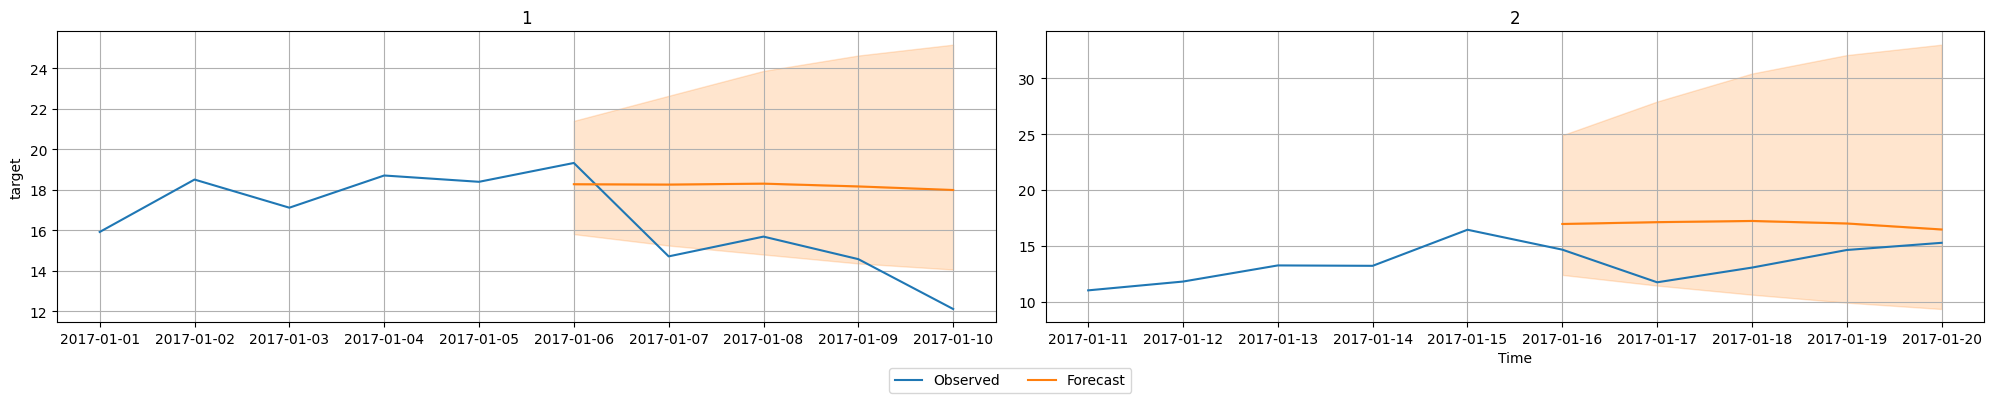

In [50]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=data,
    predictions=predictions,
    item_ids=data.item_ids[:2],
    max_history_length=200,
);

# Test Nummer 3

In [125]:
%matplotlib inline
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
import pandas as pd

In [72]:
df = pd.read_csv("neuTemp.csv")
df.head()

,item_id,timestamp,target
0,1,2022-05-01,14
1,1,2022-06-01,19
2,1,2022-07-01,16
3,1,2022-08-01,16
4,1,2022-09-01,14


In [80]:
data = TimeSeriesDataFrame.from_path(
    "neuTemp.csv"
)
data.head()

target
item_id timestamp         
1       2022-05-01      14
        2022-06-01      19
        2022-07-01      16
        2022-08-01      16
        2022-09-01      14

In [122]:
prediction_length = 5
train_data, test_data = data.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data, presets="bolt_small",
)

Beginning AutoGluon training...
AutoGluon will save models to 'c:\workspace\CrimeMap\AutogluonModels\ag-20250514_170522'
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.12.1
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          8
GPU Count:          0
Memory Avail:       0.82 GB / 15.70 GB (5.2%)
Disk Space Avail:   56.37 GB / 475.50 GB (11.9%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 5,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 14 rows, 2 time series. Median time

Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]


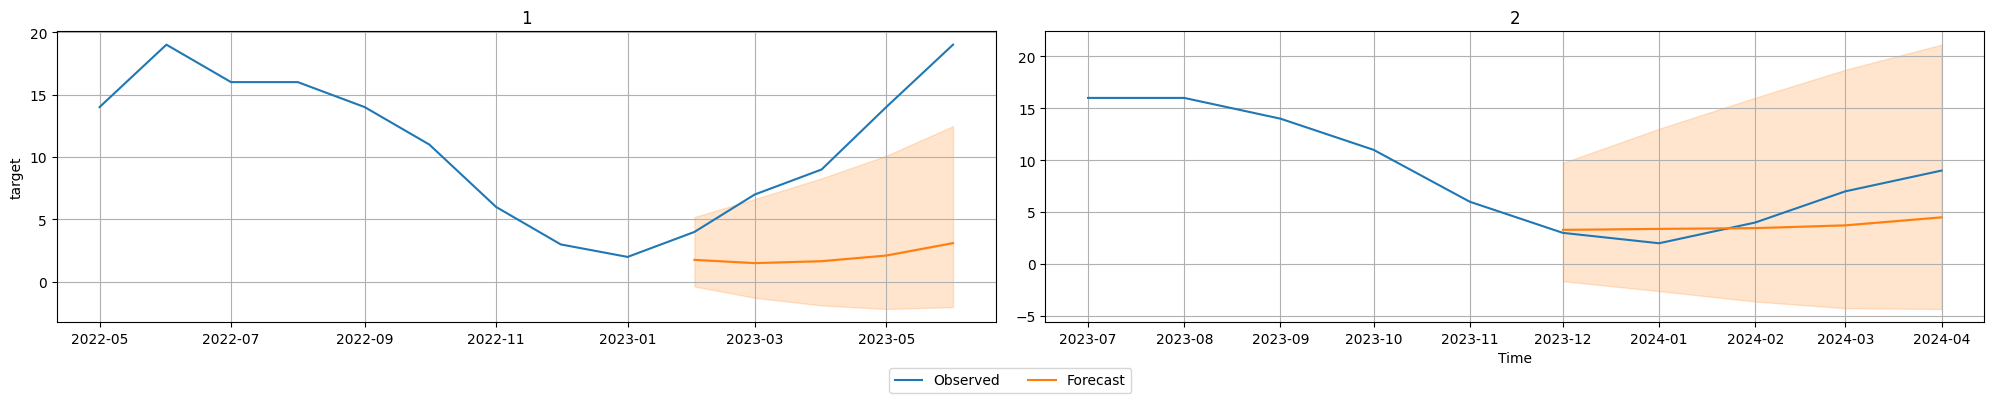

In [123]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=data,
    predictions=predictions,
    item_ids=data.item_ids[:2],
    max_history_length=200,
);

In [124]:
predictor.evaluate(test_data)

Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
c:\workspace\CrimeMap\CrimeMap_venv\Lib\site-packages\autogluon\timeseries\metrics\abstract.py:101: FutureWarning: Passing `prediction_length` to `TimeSeriesScorer.__call__` is deprecated and will be removed in v2.0. Please set the `eval_metric.prediction_length` attribute instead.
  warnings.warn(


{'WQL': np.float64(-0.5469985059863142)}

In [83]:
predictor.leaderboard(test_data)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
c:\workspace\CrimeMap\CrimeMap_venv\Lib\site-packages\autogluon\timeseries\metrics\abstract.py:101: FutureWarning: Passing `prediction_length` to `TimeSeriesScorer.__call__` is deprecated and will be removed in v2.0. Please set the `eval_metric.prediction_length` attribute instead.
  warnings.warn(


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,Chronos[bolt_small],-0.546999,None,0.992742,None,0.007045,1


In [111]:
len(data)
#data

24

In [109]:
len(train_data)
#train_data

14

In [110]:
len(test_data)
#test_data

24

In [ ]:
df = pd.read_csv("Temp-single.csv")
df.head()

,item_id,Monat,timestamp
0,1,2022-05-01,14
1,1,2022-06-01,19
2,1,2022-07-01,16
3,1,2022-08-01,16
4,1,2022-09-01,14


In [134]:
data = TimeSeriesDataFrame.from_path(
    "Temp-single.csv"
)
data.head()

target
item_id timestamp         
1       2022-05-01      14
        2022-06-01      19
        2022-07-01      16
        2022-08-01      16
        2022-09-01      14

In [135]:
prediction_length = 5
train_data, test_data = data.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data, presets="bolt_small",
)

Beginning AutoGluon training...
AutoGluon will save models to 'c:\workspace\CrimeMap\AutogluonModels\ag-20250514_183846'
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.12.1
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          8
GPU Count:          0
Memory Avail:       0.61 GB / 15.70 GB (3.9%)
Disk Space Avail:   56.44 GB / 475.50 GB (11.9%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 5,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'MS'
Provided train_data has 19 rows, 1 time series. Median time

Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]


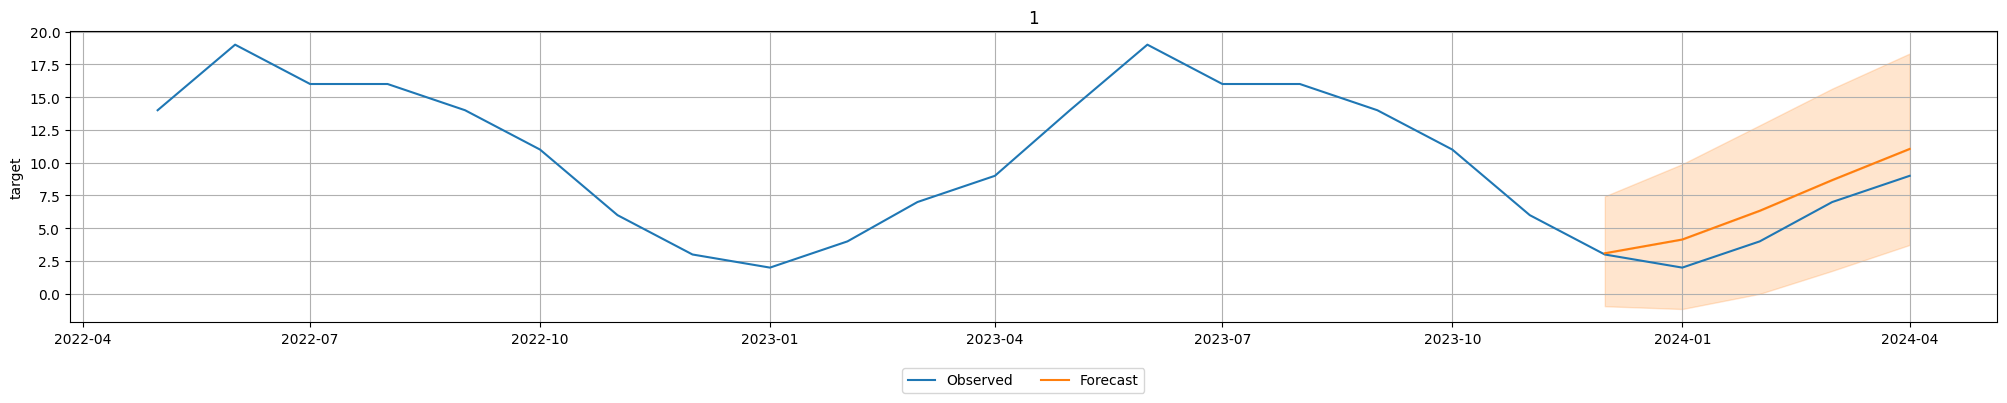

In [136]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=data,
    predictions=predictions,
    item_ids=data.item_ids[:2],
    max_history_length=200,
);

# Test mit größerem Datensatz

In [137]:
data = TimeSeriesDataFrame.from_path(
    "timeseries-temperature.csv"
)
data.head()

target
item_id timestamp                  
0       1980-01-01 00:00:00    12.7
        1980-01-01 01:00:00    12.9
        1980-01-01 02:00:00    13.2
        1980-01-01 03:00:00    15.9
        1980-01-01 04:00:00    19.4

In [144]:
prediction_length = 50
train_data, test_data = data.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data, presets="bolt_small",
)

Beginning AutoGluon training...
AutoGluon will save models to 'c:\workspace\CrimeMap\AutogluonModels\ag-20250514_190101'
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.12.1
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          8
GPU Count:          0
Memory Avail:       0.81 GB / 15.70 GB (5.2%)
Disk Space Avail:   56.11 GB / 475.50 GB (11.8%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 50,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 389446 rows, 1 time series. Median 

Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]


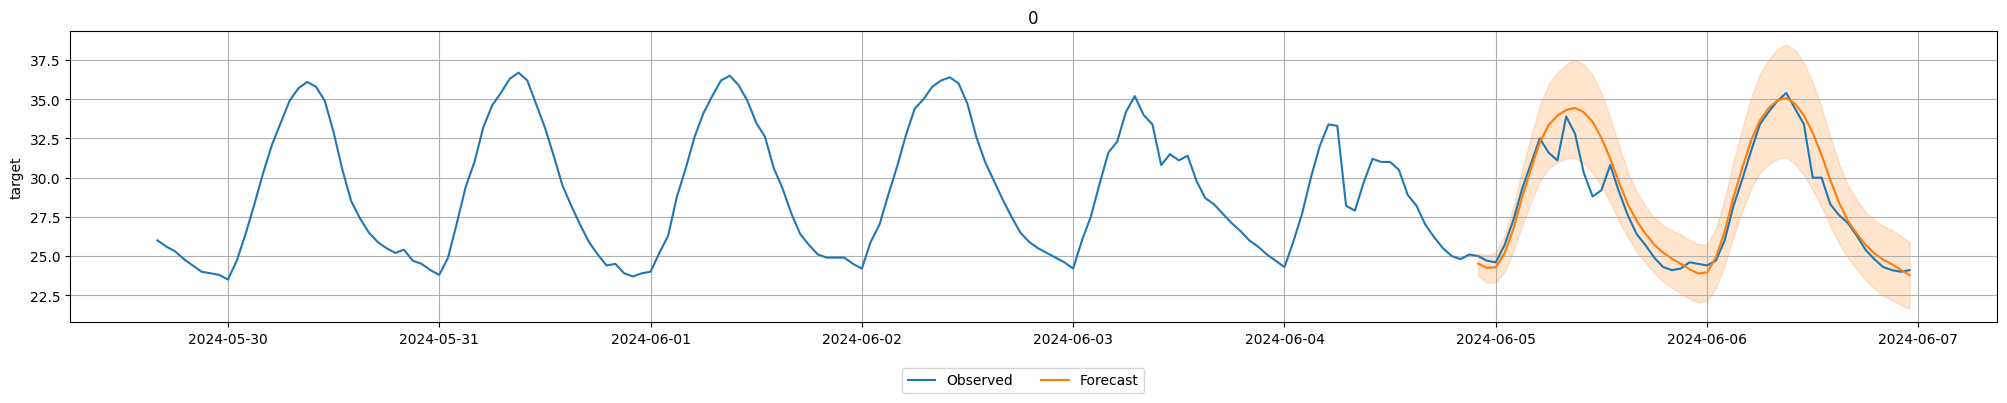

In [145]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=data,
    predictions=predictions,
    item_ids=data.item_ids[:2],
    max_history_length=200,
);

# Test mit Fake-Zahlen und verschiedenen Modellen

In [165]:
data = TimeSeriesDataFrame.from_path(
    "test1.csv"
)
data.head()

target
item_id timestamp         
1       2001-01-01     245
        2002-01-01     473
        2003-01-01     380
        2004-01-01     326
        2005-01-01     231

In [172]:
prediction_length = 5
train_data, test_data = data.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data, presets="medium_quality",
)

Beginning AutoGluon training...
AutoGluon will save models to 'c:\workspace\CrimeMap\AutogluonModels\ag-20250514_211811'
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.12.1
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          8
GPU Count:          0
Memory Avail:       0.92 GB / 15.70 GB (5.9%)
Disk Space Avail:   52.99 GB / 475.50 GB (11.1%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': 'light',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 5,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'YS-JAN'
Provided train_data has 20 rows, 1 time series. Median time series length is 20 (min

Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]


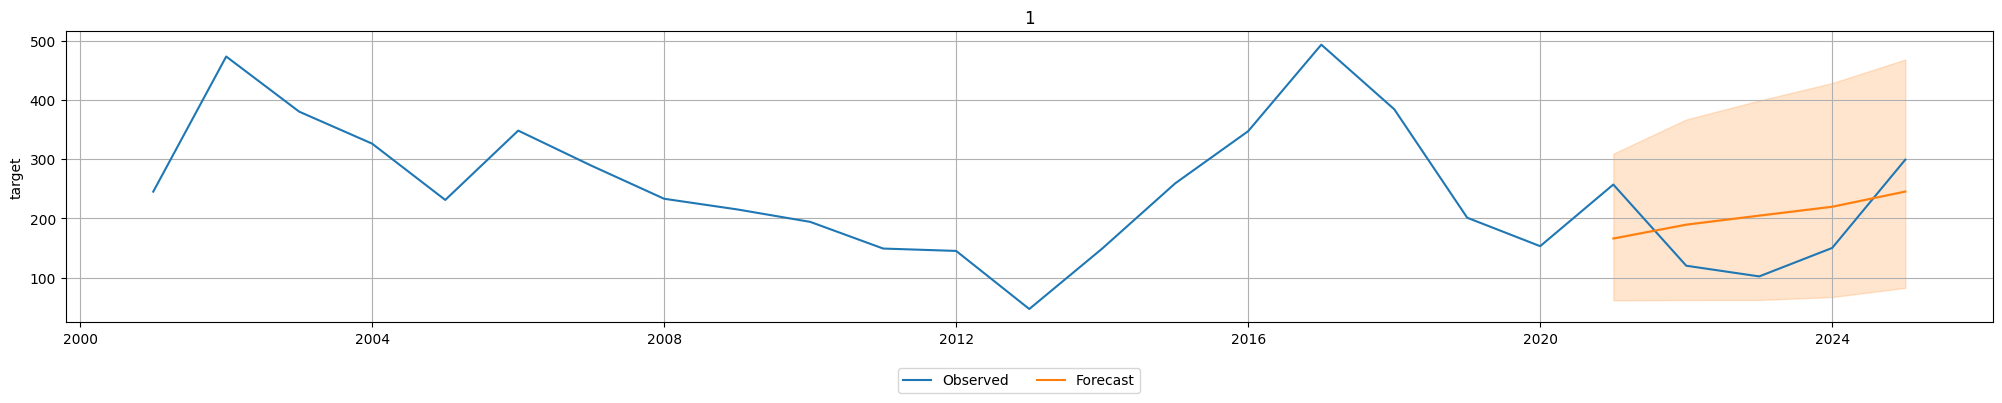

In [169]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=data,
    predictions=predictions,
    item_ids=data.item_ids[:2],
    max_history_length=200,
);

Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]


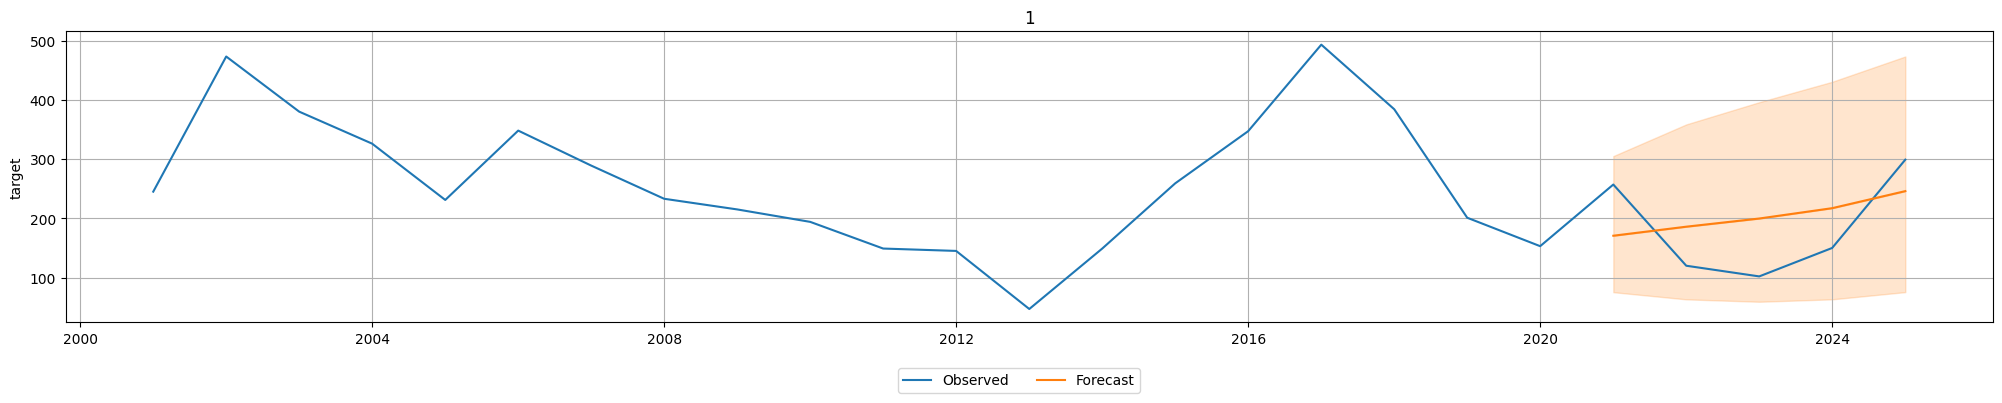

In [171]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=data,
    predictions=predictions,
    item_ids=data.item_ids[:2],
    max_history_length=200,
);

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


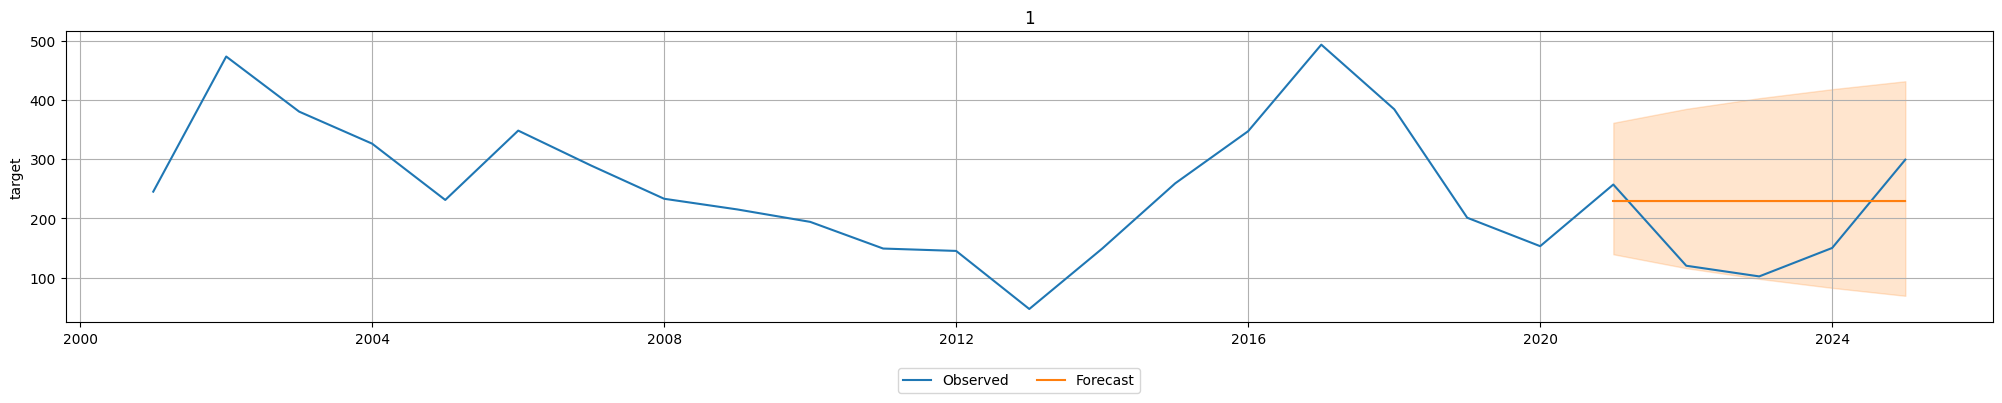

In [173]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=data,
    predictions=predictions,
    item_ids=data.item_ids[:2],
    max_history_length=200,
);

In [174]:
predictor.leaderboard(test_data)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
c:\workspace\CrimeMap\CrimeMap_venv\Lib\site-packages\autogluon\timeseries\metrics\abstract.py:101: FutureWarning: Passing `prediction_length` to `TimeSeriesScorer.__call__` is deprecated and will be removed in v2.0. Please set the `eval_metric.prediction_length` attribute instead.
  warnings.warn(
c:\workspace\CrimeMap\CrimeMap_venv\Lib\site-packages\autogluon\timeseries\metrics\abstract.py:101: FutureWarning: Passing `prediction_length` to `TimeSeriesScorer.__call__` is deprecated and will be removed in v2.0. Please set the `eval_metric.prediction_length` attribute instead.
  warnings.warn(
c:\workspace\CrimeMap\CrimeMap_venv\Lib\site-packages\autogluon\timeseries\metrics\abstract.py:101: FutureWarning: Passing `prediction_length` to `TimeSeriesScorer.__call__` is deprecated and will be removed in v2.0. Please set the `eval_metric.prediction_length` attri

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,Chronos[bolt_small],-0.292202,-0.293920,2.878300,1.765069,0.025259,7
1,WeightedEnsemble,-0.324664,-0.268111,0.259572,5.549798,4.438472,9
2,SeasonalNaive,-0.334080,-0.285982,0.021092,4.224698,0.019516,2
3,Naive,-0.334080,-0.285982,0.083400,5.495898,0.064658,1
4,ETS,-0.346348,-0.373264,0.136938,10.317066,0.012930,5
5,Theta,-0.348595,-0.482815,0.107023,4.590814,0.014161,6
6,RecursiveTabular,-0.362375,-0.293040,0.071170,0.061966,2.764651,3
7,TemporalFusionTransformer,-0.400225,-0.601920,0.090059,0.118076,215.377352,8
8,DirectTabular,-0.536206,-0.283777,0.175173,0.053900,0.693514,4


In [175]:
prediction_length = 5
train_data, test_data = data.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data, presets="high_quality",
)

Beginning AutoGluon training...
AutoGluon will save models to 'c:\workspace\CrimeMap\AutogluonModels\ag-20250514_213527'
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.12.1
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          8
GPU Count:          0
Memory Avail:       4.76 GB / 15.70 GB (30.3%)
Disk Space Avail:   54.29 GB / 475.50 GB (11.4%)
Setting presets to: high_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 5,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'YS-JAN'
Provided train_data has 20 rows, 1 time series. Median time series length is 20 (mi

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


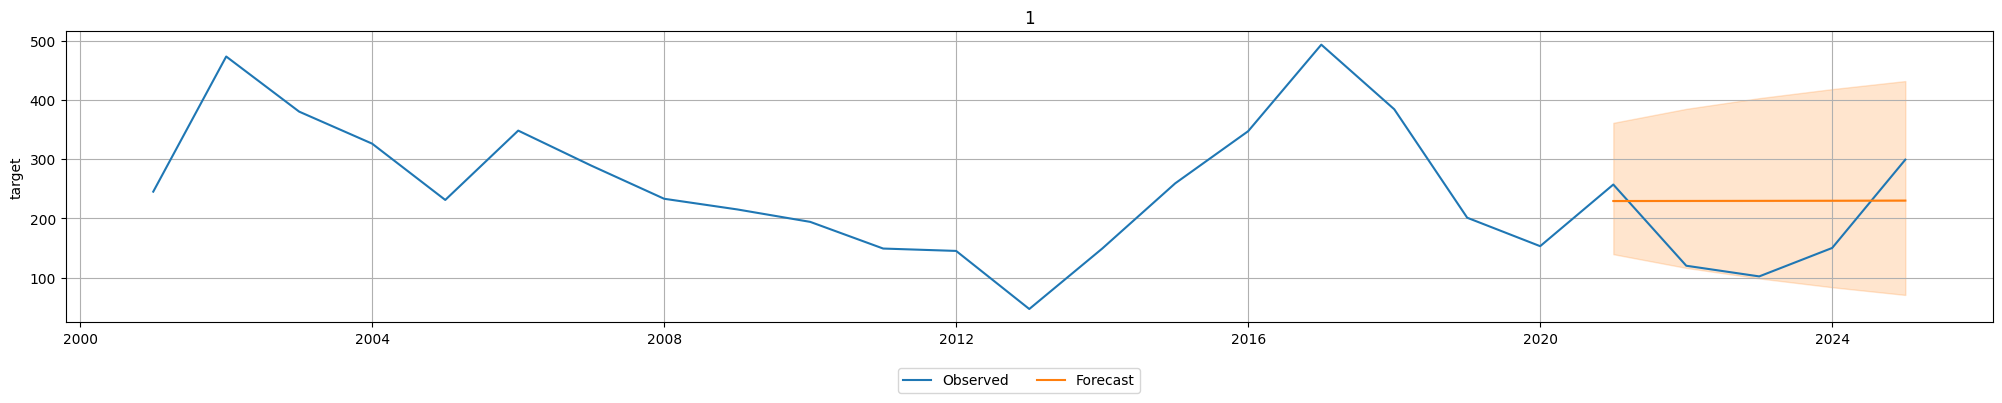

In [176]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=data,
    predictions=predictions,
    item_ids=data.item_ids[:2],
    max_history_length=200,
);

In [177]:
predictor.leaderboard(test_data)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
c:\workspace\CrimeMap\CrimeMap_venv\Lib\site-packages\autogluon\timeseries\metrics\abstract.py:101: FutureWarning: Passing `prediction_length` to `TimeSeriesScorer.__call__` is deprecated and will be removed in v2.0. Please set the `eval_metric.prediction_length` attribute instead.
  warnings.warn(
c:\workspace\CrimeMap\CrimeMap_venv\Lib\site-packages\autogluon\timeseries\metrics\abstract.py:101: FutureWarning: Passing `prediction_length` to `TimeSeriesScorer.__call__` is deprecated and will be removed in v2.0. Please set the `eval_metric.prediction_length` attribute instead.
  warnings.warn(
c:\workspace\CrimeMap\CrimeMap_venv\Lib\site-packages\autogluon\timeseries\metrics\abstract.py:101: FutureWarning: Passing `prediction_length` to `TimeSeriesScorer.__call__` is deprecated and will be removed in v2.0. Please set the `eval_metric.prediction_length` attri

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,TiDE,-0.226532,-0.636070,0.416379,0.029597,186.119824,12
1,ChronosFineTuned[bolt_small],-0.278585,-0.515467,1.661761,0.038907,450.960366,8
2,ChronosZeroShot[bolt_base],-0.283172,-0.282344,1.157771,2.129973,0.014537,7
3,DeepAR,-0.321739,-0.452818,0.121399,0.036827,28.424531,10
4,WeightedEnsemble,-0.324797,-0.268130,3.227348,5.182545,1.787802,13
5,PatchTST,-0.330203,-0.552123,0.122495,0.020688,28.080318,11
6,DynamicOptimizedTheta,-0.333842,-0.346603,8.996473,2.738819,0.012408,5
7,SeasonalNaive,-0.334080,-0.285982,2.026343,3.016013,0.019631,1
8,AutoETS,-0.346348,-0.373264,18.969357,2.531369,0.011235,6
9,RecursiveTabular,-0.362375,-0.293040,0.215216,0.042272,0.663059,2


# Ermittlung der Mindestgröße des Datensatzes

In [19]:
data = TimeSeriesDataFrame.from_path(
    "test1.csv"
)
data.head()

target
item_id timestamp         
1       1960-01-01     172
        1961-01-01     199
        1962-01-01     312
        1963-01-01     287
        1964-01-01     275

In [22]:
prediction_length = 5
train_data, test_data = data.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data, presets="bolt_small",
)

Beginning AutoGluon training...
AutoGluon will save models to 'c:\workspace\CrimeMap\AutogluonModels\ag-20250515_111756'
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.12.1
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          8
GPU Count:          0
Memory Avail:       3.27 GB / 15.70 GB (20.9%)
Disk Space Avail:   71.56 GB / 475.50 GB (15.0%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 5,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'YS-JAN'
Provided train_data has 61 rows, 1 time series. Median

Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]


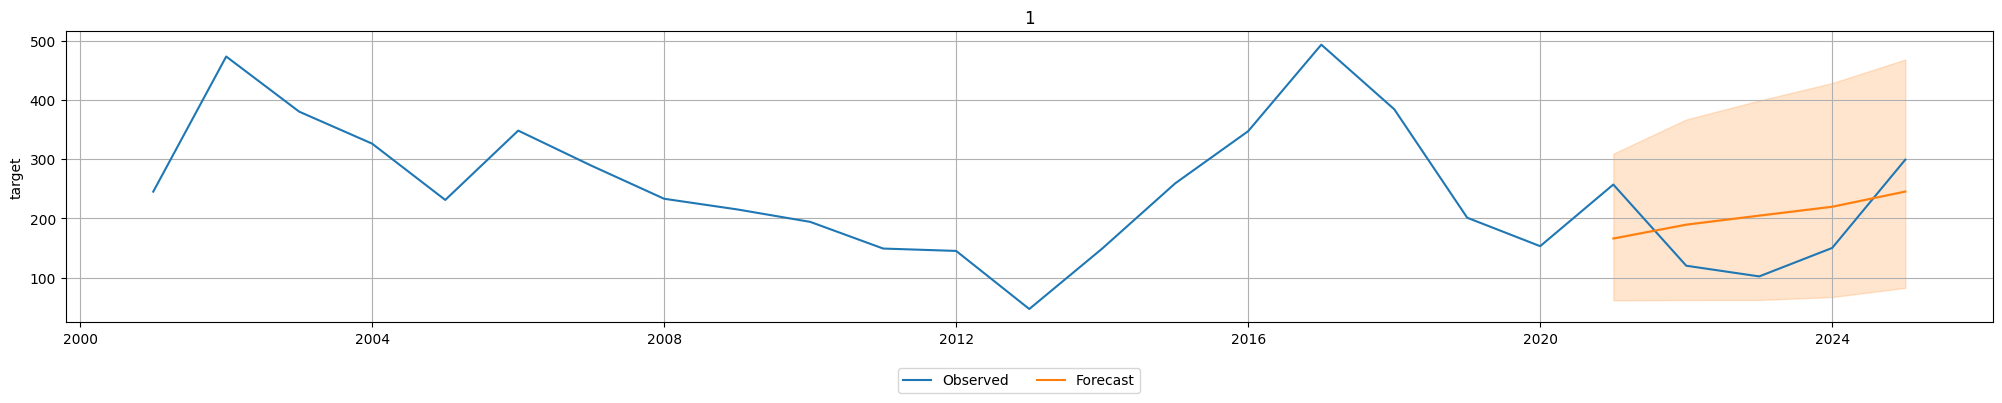

In [6]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=data,
    predictions=predictions,
    item_ids=data.item_ids[:2],
    max_history_length=200,
);

Folgend mit 45 künstliche erzeugten Datensätzen

Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]


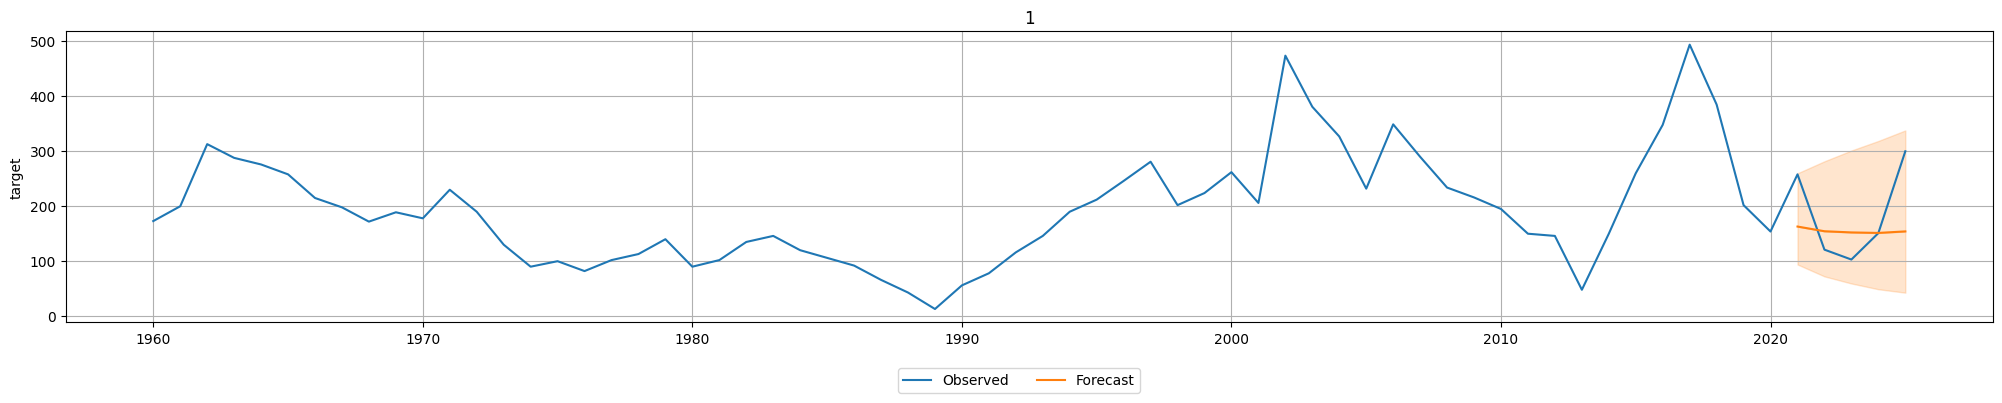

In [23]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=data,
    predictions=predictions,
    item_ids=data.item_ids[:2],
    max_history_length=200,
);

Größer des PKS-Datensatzes nicht ausreichend..

# Suche nach Alternativen - Deutsche Bahn Datensatz

In [102]:
data = TimeSeriesDataFrame.from_path(
    "timeseries-rb75.csv"
)
data.head()

target
item_id timestamp         
RB75    2024-07-08       0
        2024-07-08       0
        2024-07-08       1
        2024-07-08       0
        2024-07-08       0

In [95]:
import pandas as pd

In [103]:
df = pd.read_csv("timeseries-rb75.csv")
df.head()

,item_id,target,timestamp
0,RB75,0,2024-07-08
1,RB75,0,2024-07-08
2,RB75,1,2024-07-08
3,RB75,0,2024-07-08
4,RB75,0,2024-07-08


In [104]:
print(df.isnull().sum())


item_id      0
target       0
timestamp    0
dtype: int64


In [ ]:
prediction_length = 10
train_data, test_data = data.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length, freq="h").fit(
    train_data, presets="bolt_base",
)

Beginning AutoGluon training...
AutoGluon will save models to 'c:\workspace\CrimeMap\AutogluonModels\ag-20250515_180822'
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.12.1
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          8
GPU Count:          0
Memory Avail:       1.97 GB / 15.70 GB (12.5%)
Disk Space Avail:   61.51 GB / 475.50 GB (12.9%)
Setting presets to: bolt_base

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'min',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 10,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

train_data with frequency 'IRREG' has been resampled to frequency 'min'.
Provide

data with frequency 'IRREG' has been resampled to frequency 'min'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]
data with frequency 'IRREG' has been resampled to frequency 'min'.


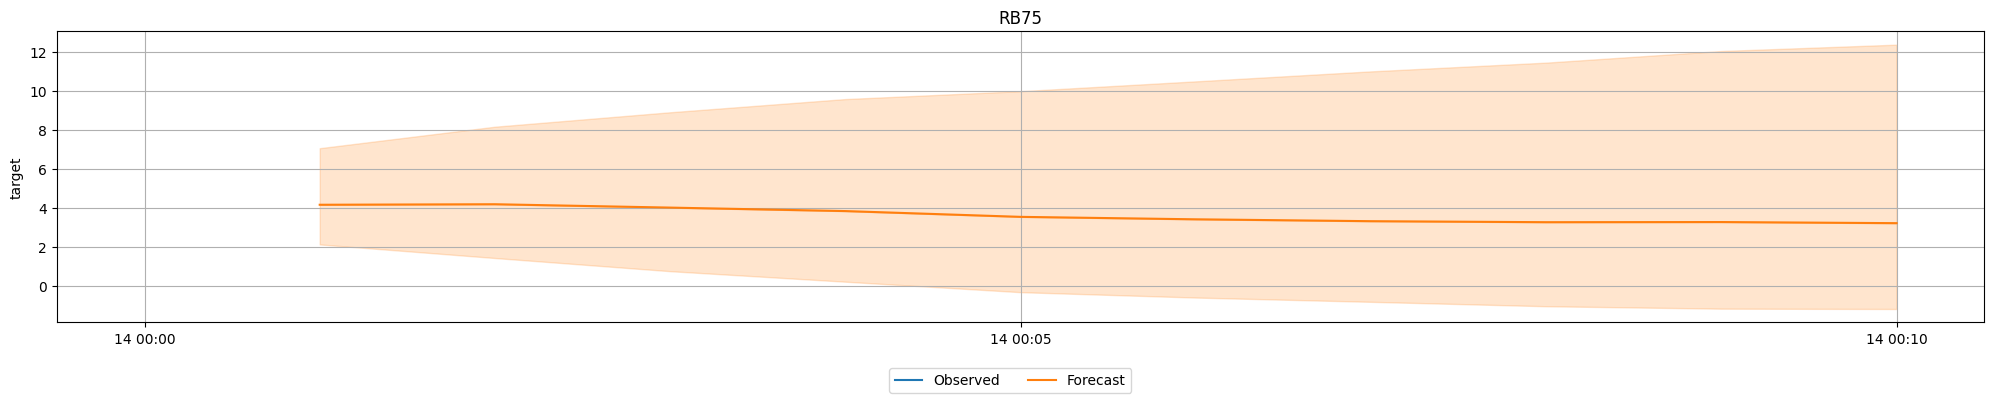

In [111]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=data,
    predictions=predictions,
    item_ids=data.item_ids[:2],
    max_history_length=200,
);

# Suche nach Alternative - Netflix Stock Price

In [51]:
data = TimeSeriesDataFrame.from_path(
    "nflx.csv"
)
data.head()

target
item_id timestamp             
0       2018-02-05  254.259995
        2018-02-06  265.720001
        2018-02-07  264.559998
        2018-02-08  250.100006
        2018-02-09  249.470001

In [52]:
prediction_length = 5
train_data, test_data = data.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length, freq="d").fit(
    train_data, presets="bolt_small",
)

Frequency 'd' stored as 'D'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\workspace\CrimeMap\AutogluonModels\ag-20250515_163143'
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.12.1
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          8
GPU Count:          0
Memory Avail:       2.01 GB / 15.70 GB (12.8%)
Disk Space Avail:   68.57 GB / 475.50 GB (14.4%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'D',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 5,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

train_data with frequency 'IRREG' has been resampled 

data with frequency 'IRREG' has been resampled to frequency 'D'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'IRREG' has been resampled to frequency 'D'.


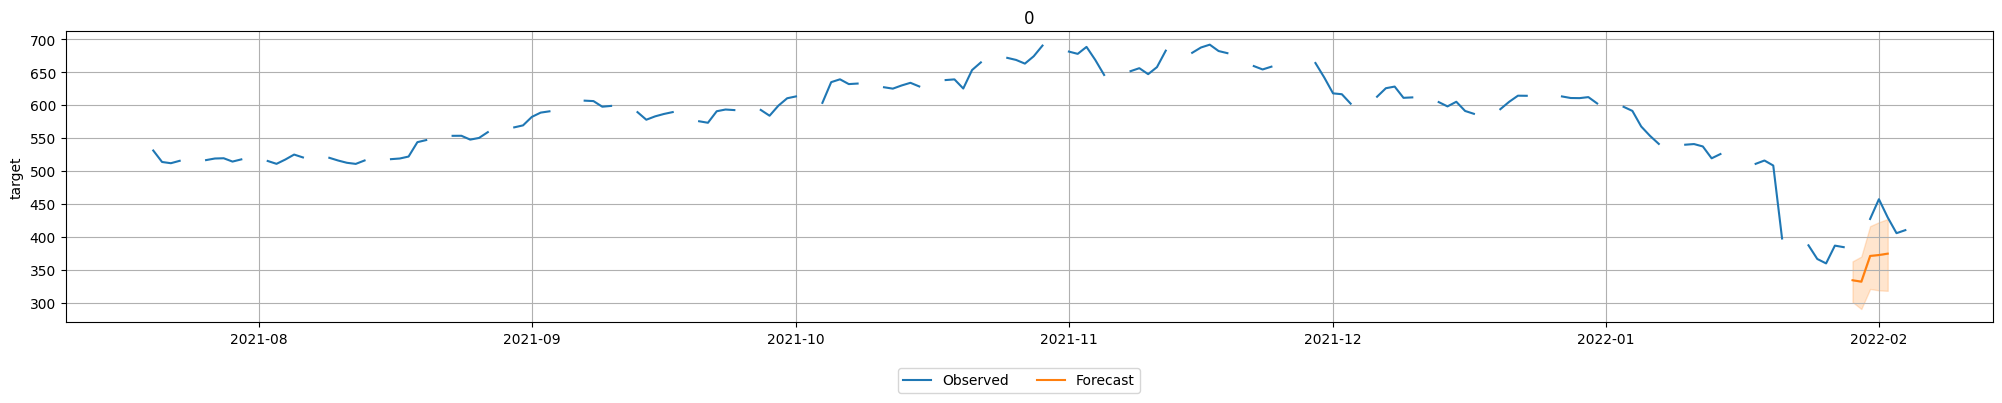

In [53]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=data,
    predictions=predictions,
    item_ids=data.item_ids[:2],
    max_history_length=200,
);

# Suche nach Alternative - Gold Prices for 5 years

In [55]:
data = TimeSeriesDataFrame.from_path(
    "gold.csv"
)
data.head()

target
item_id timestamp             
0       2019-11-11  137.059998
        2019-11-12  137.429993
        2019-11-13  137.979996
        2019-11-14  138.559998
        2019-11-15  138.210007

In [58]:
prediction_length = 5
train_data, test_data = data.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length, freq="d").fit(
    train_data, presets="bolt_small",
)

Frequency 'd' stored as 'D'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\workspace\CrimeMap\AutogluonModels\ag-20250515_163615'
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.12.1
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          8
GPU Count:          0
Memory Avail:       2.42 GB / 15.70 GB (15.4%)
Disk Space Avail:   68.57 GB / 475.50 GB (14.4%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'D',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 5,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

train_data with frequency 'IRREG' has been resampled 

data with frequency 'IRREG' has been resampled to frequency 'D'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'IRREG' has been resampled to frequency 'D'.


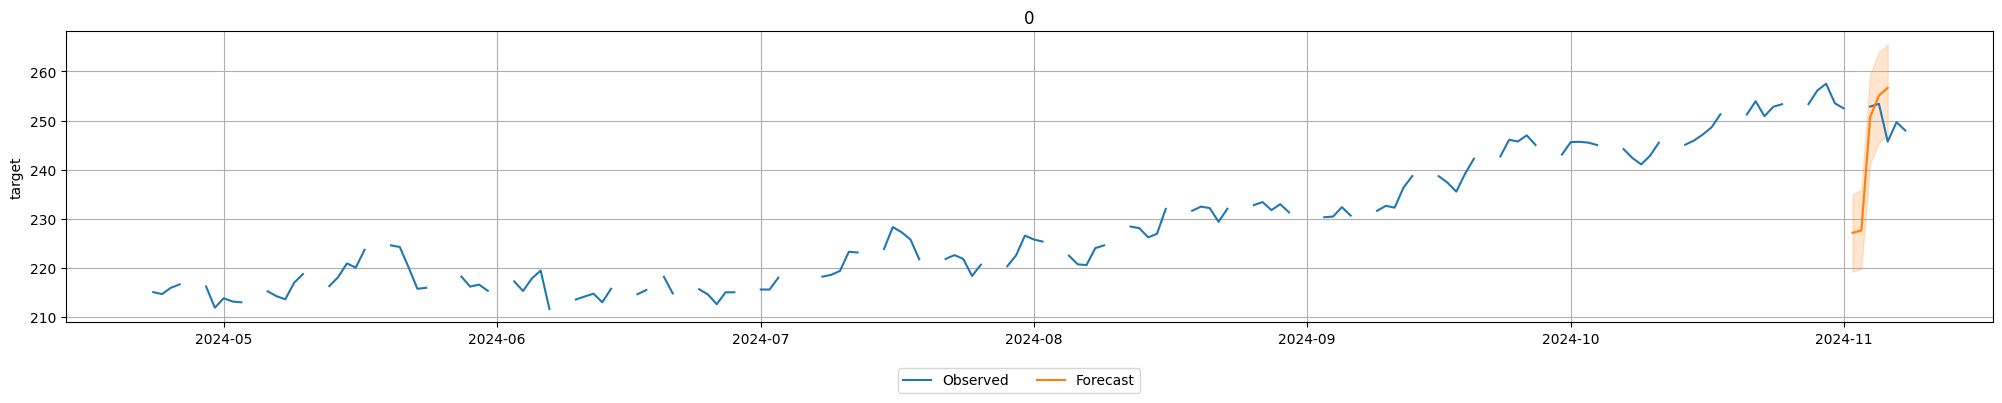

In [59]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=data,
    predictions=predictions,
    item_ids=data.item_ids[:2],
    max_history_length=200,
);